# Process and grade LLM responses

In [691]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re

# Requires LaTeX
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
import scienceplots
plt.style.use(['science','ieee'])

In [529]:
def trim_county_name(county):
    parts = county.split()
    if len(parts) > 1 and re.sub(r'[^\w]', '', parts[-1]).lower() in ("co", "county", "mun", "par", "prov"):
        return " ".join(parts[:-1])
    else:
        return county

In [690]:
# LLM = "llama2-7b"
# LLM = "gpt-3.5-turbo-0613"
LLM = "gpt-4-1106-preview"
RESULTS_WITH_UMS = f"../../results/idigbio-sample/{LLM}/results-with-ums.tsv"

full_df = pd.read_csv(RESULTS_WITH_UMS, sep="\t")
full_df["species"] = full_df["kingdom"] + " " + full_df["genus"] + " " + full_df["specificepithet"]
full_df["county"] = full_df["county"].map(trim_county_name)

# Play with the decision threshold
# full_df["prediction"] = full_df.apply(axis=1, func=lambda r: 0 if r["abstains"] == 10 else (-1 if r["scores"] / (10 - r["abstains"]) < .5 else 1))
# full_df["correct"] = full_df["prediction"] * full_df["target"]

In [531]:
import regex as re
pattern = re.compile("^um[0-9]+_.+")

all_features = [c for c in full_df.columns if pattern.match(c) is not None]

print("Num uncertainty measures:", len(all_features))
print("\n".join(all_features))

Num uncertainty measures: 21
um1_total_score
um1_percent_score
um2_abstains
um4_phrasing_agreement
um4_phrasing_score_var
um5_record_count_by_phylum
um5_record_count_by_family
um5_record_count_by_genus
um5_record_count_by_species
um5_record_count_by_stateprovince
um5_record_count_by_county
um6_taxqa_accuracy_by_phylum
um6_taxqa_accuracy_by_class
um6_taxqa_accuracy_by_order
um6_taxqa_accuracy_by_family
um6_taxqa_accuracy_by_genus
um7_taxqa_responses_by_phylum
um7_taxqa_responses_by_class
um7_taxqa_responses_by_order
um7_taxqa_responses_by_family
um7_taxqa_responses_by_genus


In [532]:
response_features = {
    'um1_total_score',
    'um1_percent_score',
    'um2_abstains'
}

acc_features = {
    'um3_accuracy_by_kingdom',
    'um3_accuracy_by_phylum',
    "um3_accuracy_by_family",
    'um3_accuracy_by_country',
    'um3_accuracy_by_stateprovince'
}

phrasing_features = {
    'um4_phrasing_agreement',
    'um4_phrasing_score_var'
}

idb_features = {
    'um5_record_count_by_phylum',
    'um5_record_count_by_family',
    'um5_record_count_by_genus',
    'um5_record_count_by_species',
    'um5_record_count_by_stateprovince',
    'um5_record_count_by_county'
}

taxonomy_features = {
    'um6_taxqa_accuracy_by_phylum',
    'um6_taxqa_accuracy_by_class',
    'um6_taxqa_accuracy_by_order',
    'um6_taxqa_accuracy_by_family',
    'um6_taxqa_accuracy_by_genus',
    'um7_taxqa_responses_by_phylum',
    'um7_taxqa_responses_by_class',
    'um7_taxqa_responses_by_order',
    'um7_taxqa_responses_by_family',
    'um7_taxqa_responses_by_genus'
}

basic_features = list(set()\
    | response_features\
    | phrasing_features\
    | idb_features\
    | taxonomy_features\
)

ext_features = list(set(basic_features) | acc_features)

In [533]:
full_df.groupby("correct")[list(set(basic_features) - acc_features)].mean()

,um5_record_count_by_stateprovince,um6_taxqa_accuracy_by_phylum,um4_phrasing_agreement,um5_record_count_by_county,um6_taxqa_accuracy_by_order,um5_record_count_by_species,um7_taxqa_responses_by_genus,um7_taxqa_responses_by_phylum,um5_record_count_by_genus,um2_abstains,um6_taxqa_accuracy_by_class,um5_record_count_by_phylum,um6_taxqa_accuracy_by_genus,um1_percent_score,um7_taxqa_responses_by_family,um1_total_score,um6_taxqa_accuracy_by_family,um5_record_count_by_family,um4_phrasing_score_var
correct,,,,,,,,,,,,,,,,,,,
-1,1.817678e+06,1.0,0.631838,58925.820058,0.894973,2650.823776,-0.007588,0.0,33913.873321,9.822097,0.907460,5.193944e+06,0.804453,0.938326,-0.003661,9.297025,0.845492,256407.177183,-4.953471
1,1.596117e+06,1.0,0.794662,53993.844246,0.889105,4995.664355,-0.005422,0.0,48130.526404,9.942592,0.896103,6.607861e+06,0.837956,0.910543,-0.002818,9.080211,0.861263,318242.508668,-3.724239


In [393]:
df = full_df.groupby("correct")[basic_features].mean().transpose().sort_index()
df[-1] < df[1]

um1_percent_score                    False
um1_total_score                      False
um2_abstains                          True
um4_phrasing_agreement                True
um4_phrasing_score_var                True
um5_record_count_by_county           False
um5_record_count_by_family            True
um5_record_count_by_genus             True
um5_record_count_by_phylum            True
um5_record_count_by_species           True
um5_record_count_by_stateprovince    False
um6_taxqa_accuracy_by_class          False
um6_taxqa_accuracy_by_family          True
um6_taxqa_accuracy_by_genus           True
um6_taxqa_accuracy_by_order          False
um6_taxqa_accuracy_by_phylum         False
um7_taxqa_responses_by_family         True
um7_taxqa_responses_by_genus          True
um7_taxqa_responses_by_phylum        False
dtype: bool

In [682]:
def get_acc_by_field(df, fields, prior_counts=1) -> pd.Series:
    new_index = df.groupby(fields).size().index
    def fill_blanks(series):
        return series.reindex(new_index, fill_value=0)
    
    subset = True
    num_correct = prior_counts + fill_blanks(df[subset * (df["correct"] == 1)].groupby(fields).size())
    num_incorrect = prior_counts + fill_blanks(df[subset * (df["correct"] == -1)].groupby(fields).size())
    
    return num_correct / (num_correct + num_incorrect)

In [683]:
def get_field_acc(accs, record):
    i = tuple(record[accs.index.names])
    if i in accs.index:
        return accs.loc[i]
    else:
        return acc_by_kingdom.loc[record["kingdom"]]

def add_acc_ums(train_df, test_df):
    df = train_df
    acc_by_kingdom = get_acc_by_field(train_df, ["kingdom"])
    acc_by_phylum = get_acc_by_field(df, ["kingdom", "phylum"])
    acc_by_family = get_acc_by_field(df, ["kingdom", "phylum", "family"])
    # acc_by_genus = get_acc_by_field(df, ["kingdom", "phylum", "family", "genus"])
    # acc_by_species = get_acc_by_field(df, ["kingdom", "phylum", "family", "genus", "specificepithet"])
    acc_by_country = get_acc_by_field(df, ["country"])
    acc_by_stateprovince = get_acc_by_field(df, ["stateprovince"])
    # acc_by_county = get_acc_by_field(df, ["county"])

    def get_ums(record):
        r = record

        # Positively oriented, i.e. higher values = more certainty
        return pd.Series({    
            "um3_accuracy_by_kingdom": 1 - get_field_acc(acc_by_kingdom, r),
            "um3_accuracy_by_phylum": 1 - get_field_acc(acc_by_phylum, r),
            "um3_accuracy_by_family": 1 - get_field_acc(acc_by_family, r),
            # "um3_acc_by_genus": 1 - get_field_acc(acc_by_genus, r),
            # "um3_acc_by_species": 1 - get_field_acc(acc_by_species, r),
            "um3_accuracy_by_country": 1 - get_field_acc(acc_by_country, r),
            "um3_accuracy_by_stateprovince": 1 - get_field_acc(acc_by_stateprovince, r),
            # "um3_acc_by_county": 1 - get_field_acc(acc_by_county, r),
        })

    train_df = pd.concat([train_df.apply(lambda row: get_ums(row), axis=1), train_df], axis=1)
    test_df = pd.concat([test_df.apply(lambda row: get_ums(row), axis=1), test_df], axis=1)
    return (train_df, test_df)

k-fold cross validation

In [684]:
from sklearn.ensemble import HistGradientBoostingClassifier

def train_conf_model(train_df, features):
    return HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.01,
        min_samples_leaf=10,
        max_iter=200,
        monotonic_cst=np.ones_like(features, dtype=int)
    ).fit(train_df[features], train_df["correct"])

In [685]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
import numpy as np

k = 5
prediction_value, prediction_label = -1, "Absence"
# prediction_value, prediction_label = 1, "Presence"

cv = KFold(n_splits=k)

full_df["split_groups"] = full_df["species"]
df = full_df[full_df["prediction"] == prediction_value]

split_groups = df["split_groups"].unique()
np.random.shuffle(split_groups)

p_results = [] # Precision arrays
r_results = [] # Recall arrays
t_results = [] # High-confidence threshold arrays

trains = []
tests = []
for fold, (train, test) in enumerate(cv.split(split_groups)):
    train_df, test_df = add_acc_ums(\
        df[df["split_groups"].isin(split_groups[train])],\
        df[df["split_groups"].isin(split_groups[test])])
    
    conf_model = train_conf_model(train_df, ext_features)
    probs = conf_model.predict_proba(test_df[ext_features])
    precision, recall, threshold = precision_recall_curve(test_df["correct"], probs[:,1]) #, drop_intermediate=True)

    p_results.append(precision)
    r_results.append(recall)
    t_results.append(threshold)


In [686]:
r = np.append(np.arange(0, 1, 0.001), 1)
r_precisions = [np.interp(r, recall[::-1], precision[::-1]) for recall, precision in zip(r_results, p_results)]

    # interp_precision = np.interp(recall_steps, recall[::-1], precision[::-1])
    # interp_threshold = np.interp(recall_steps[1:], recall[1:][::-1], threshold[::-1])
p_means = np.mean(r_precisions, axis=0)
p_stds = np.std(r_precisions, axis=0)

rn = r
rn_minus_one = np.roll(r, 1)
rn_diff = rn - rn_minus_one
average_precision = [np.sum(rn_diff[1:] * pn[1:]) for pn in r_precisions]
print(f"AP: {np.mean(average_precision):.3} ± {np.std(average_precision):.2}")

AP: 0.746 ± 0.0095


Text(0.65, 0.6, 'Average precision: 0.746 ± 0.0095')

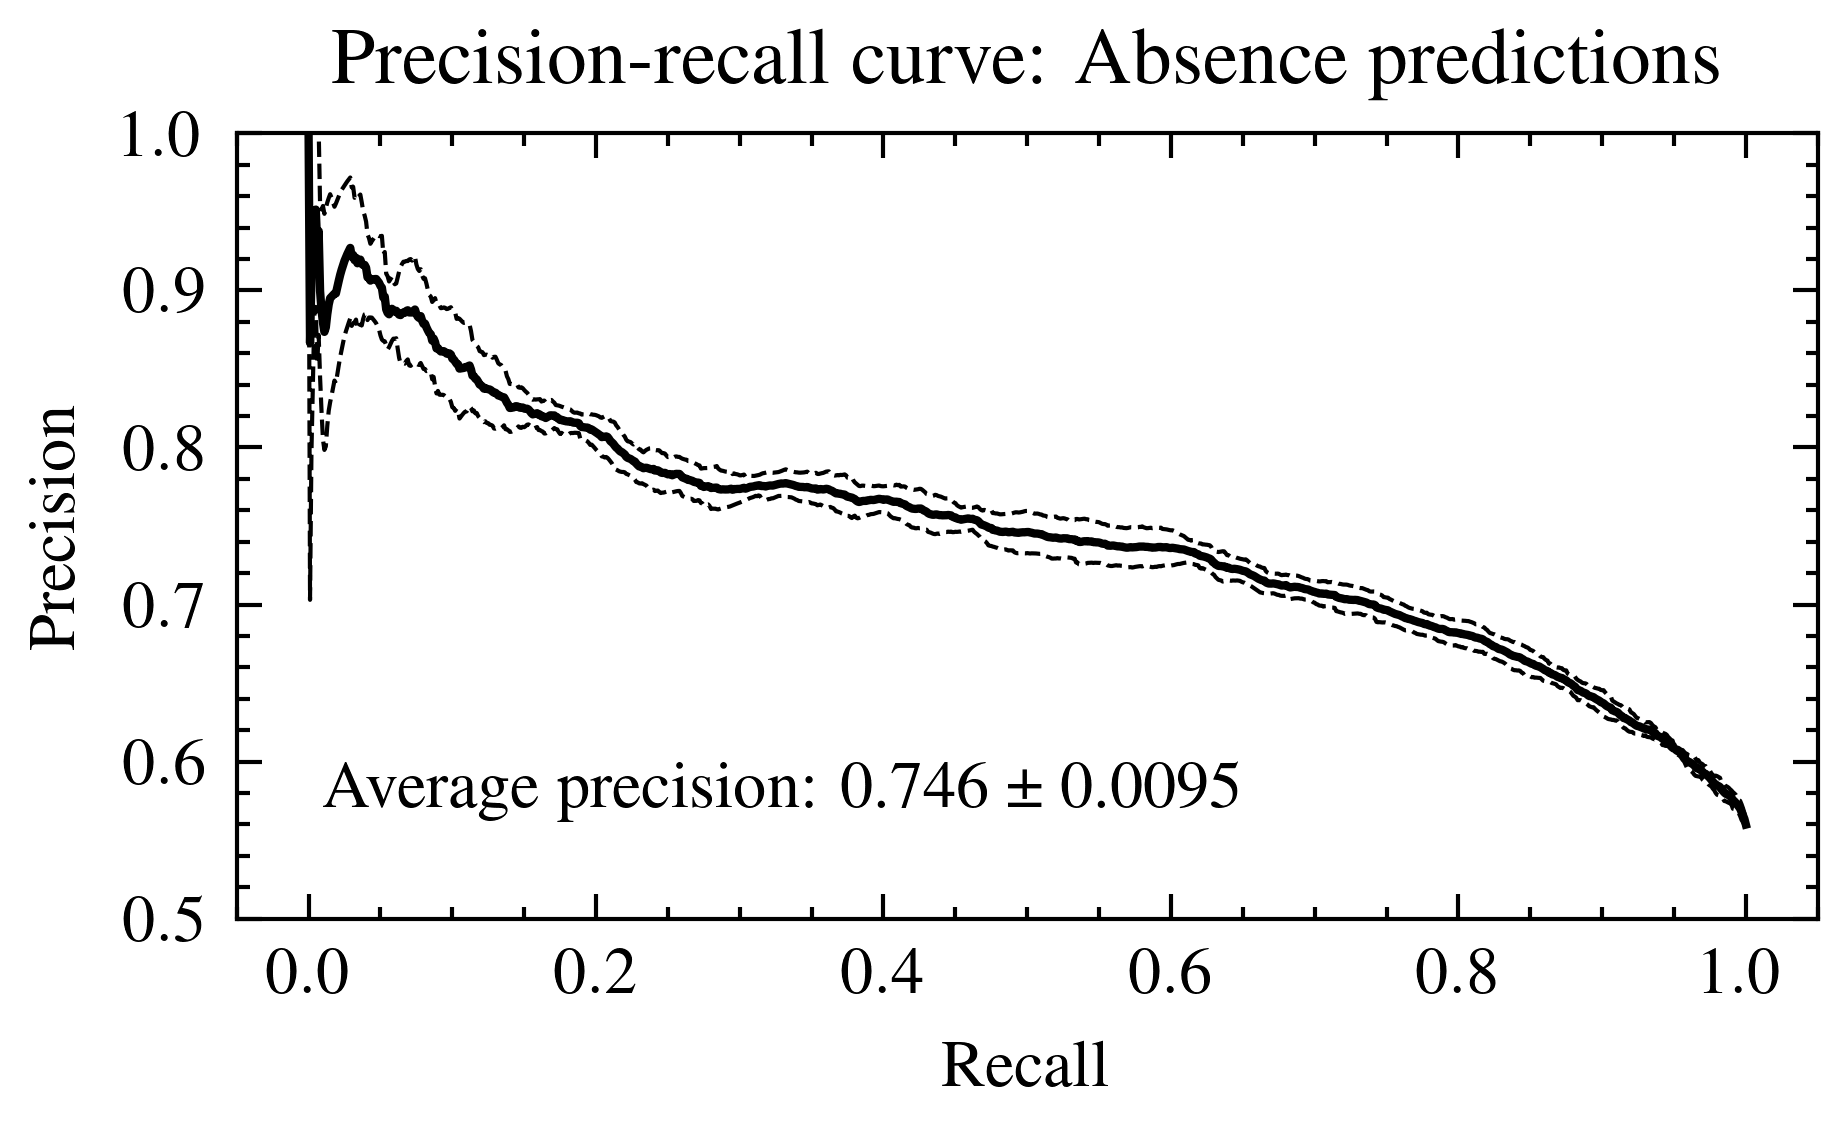

In [687]:
s = 1.7
num_stds = 1
fig, ax = plt.subplots(figsize=(2 * s, 1 * s))

ax.plot(r, p_means, color="black", label=r"Mean precision", lw=1, alpha=1.0)

for sign in (-1, 1):
    ax.plot(r, p_means + p_stds * num_stds * sign, color="black", label=r"Mean precision", lw=.5, alpha=1.0, linestyle="--")

plt.ylim(0.5, 1)
plt.title(f"Precision-recall curve: {prediction_label} predictions")
# plt.title("Presence predictions")
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.text(0.5 + .15, .5 + .1, f"Average precision: {np.mean(average_precision):.3} ± {np.std(average_precision):.2}", ha="right", va="top")

Text(0.5, 0, 'High-confidence threshold')

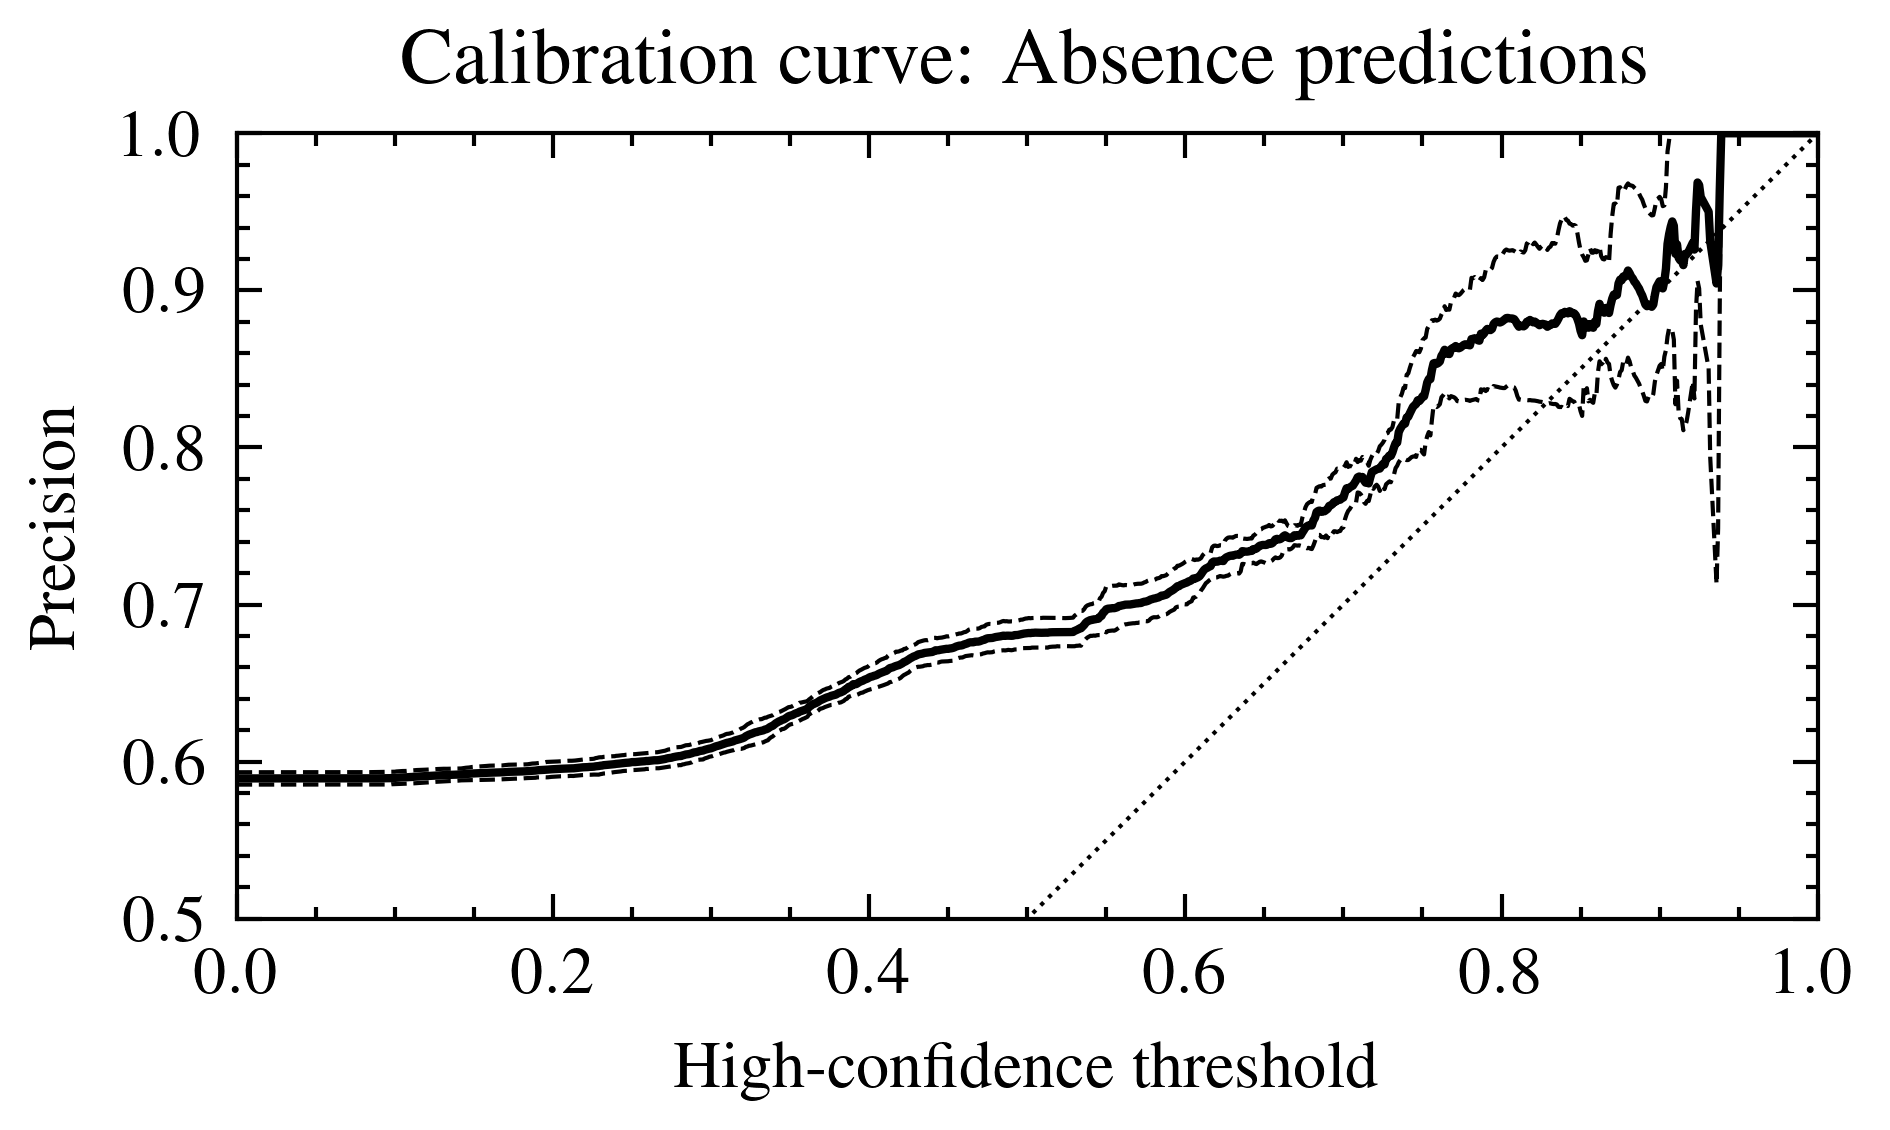

In [667]:
draw_recall = False
s = 1.7
fig, ax = plt.subplots(figsize=(2 * s, 1 * s))
plt.xlim(0, 1)
plt.ylim(0, 1)

t = np.arange(0, 1, 0.001)
t_precisions = [np.interp(t, threshold, precision[1:]) for threshold, precision in zip(t_results, p_results)]
t_recalls = [np.interp(t, threshold, recall[1:]) for threshold, recall in zip(t_results, r_results)]

# t_precisions = [np.interp(t, t_results[0][::-1], t_p[1:][::-1]) for t_p in p_results]
# t_recalls = [np.interp(t, t_results[0][::-1], t_r[1:][::-1]) for t_r in p_results]

t_p_means = np.mean(t_precisions, axis=0)
t_p_stds = np.std(t_precisions, axis=0)

t_r_means = np.mean(t_recalls, axis=0)
t_r_stds = np.std(t_recalls, axis=0)

ax.plot(t, t_p_means, color="black", label=r"Mean precision", lw=1, alpha=1.0)
if draw_recall:
    ax.plot(t, t_r_means, color="red", label=r"Mean recall", lw=.5, alpha=1.0, ls="solid")

for sign in (-1, 1):
    ax.plot(t, t_p_means + t_p_stds * 1 * sign, color="black", label=r"Mean precision", lw=.5, alpha=1.0, linestyle="--")
    if draw_recall:
        ax.plot(t, t_r_means + t_r_stds * 1 * sign, color="red", label=r"Mean precision", lw=.5, alpha=1.0, linestyle="--")

# Conservatively calibrated line
plt.plot(t, t, color="black", lw=.5, ls="dotted")

plt.ylim(0.5, 1)
plt.title(f"Calibration curve: {prediction_label} predictions")
# plt.title("Presence predictions")
plt.ylabel("Precision")
plt.xlabel("High-confidence threshold")

KeyError: 'train'

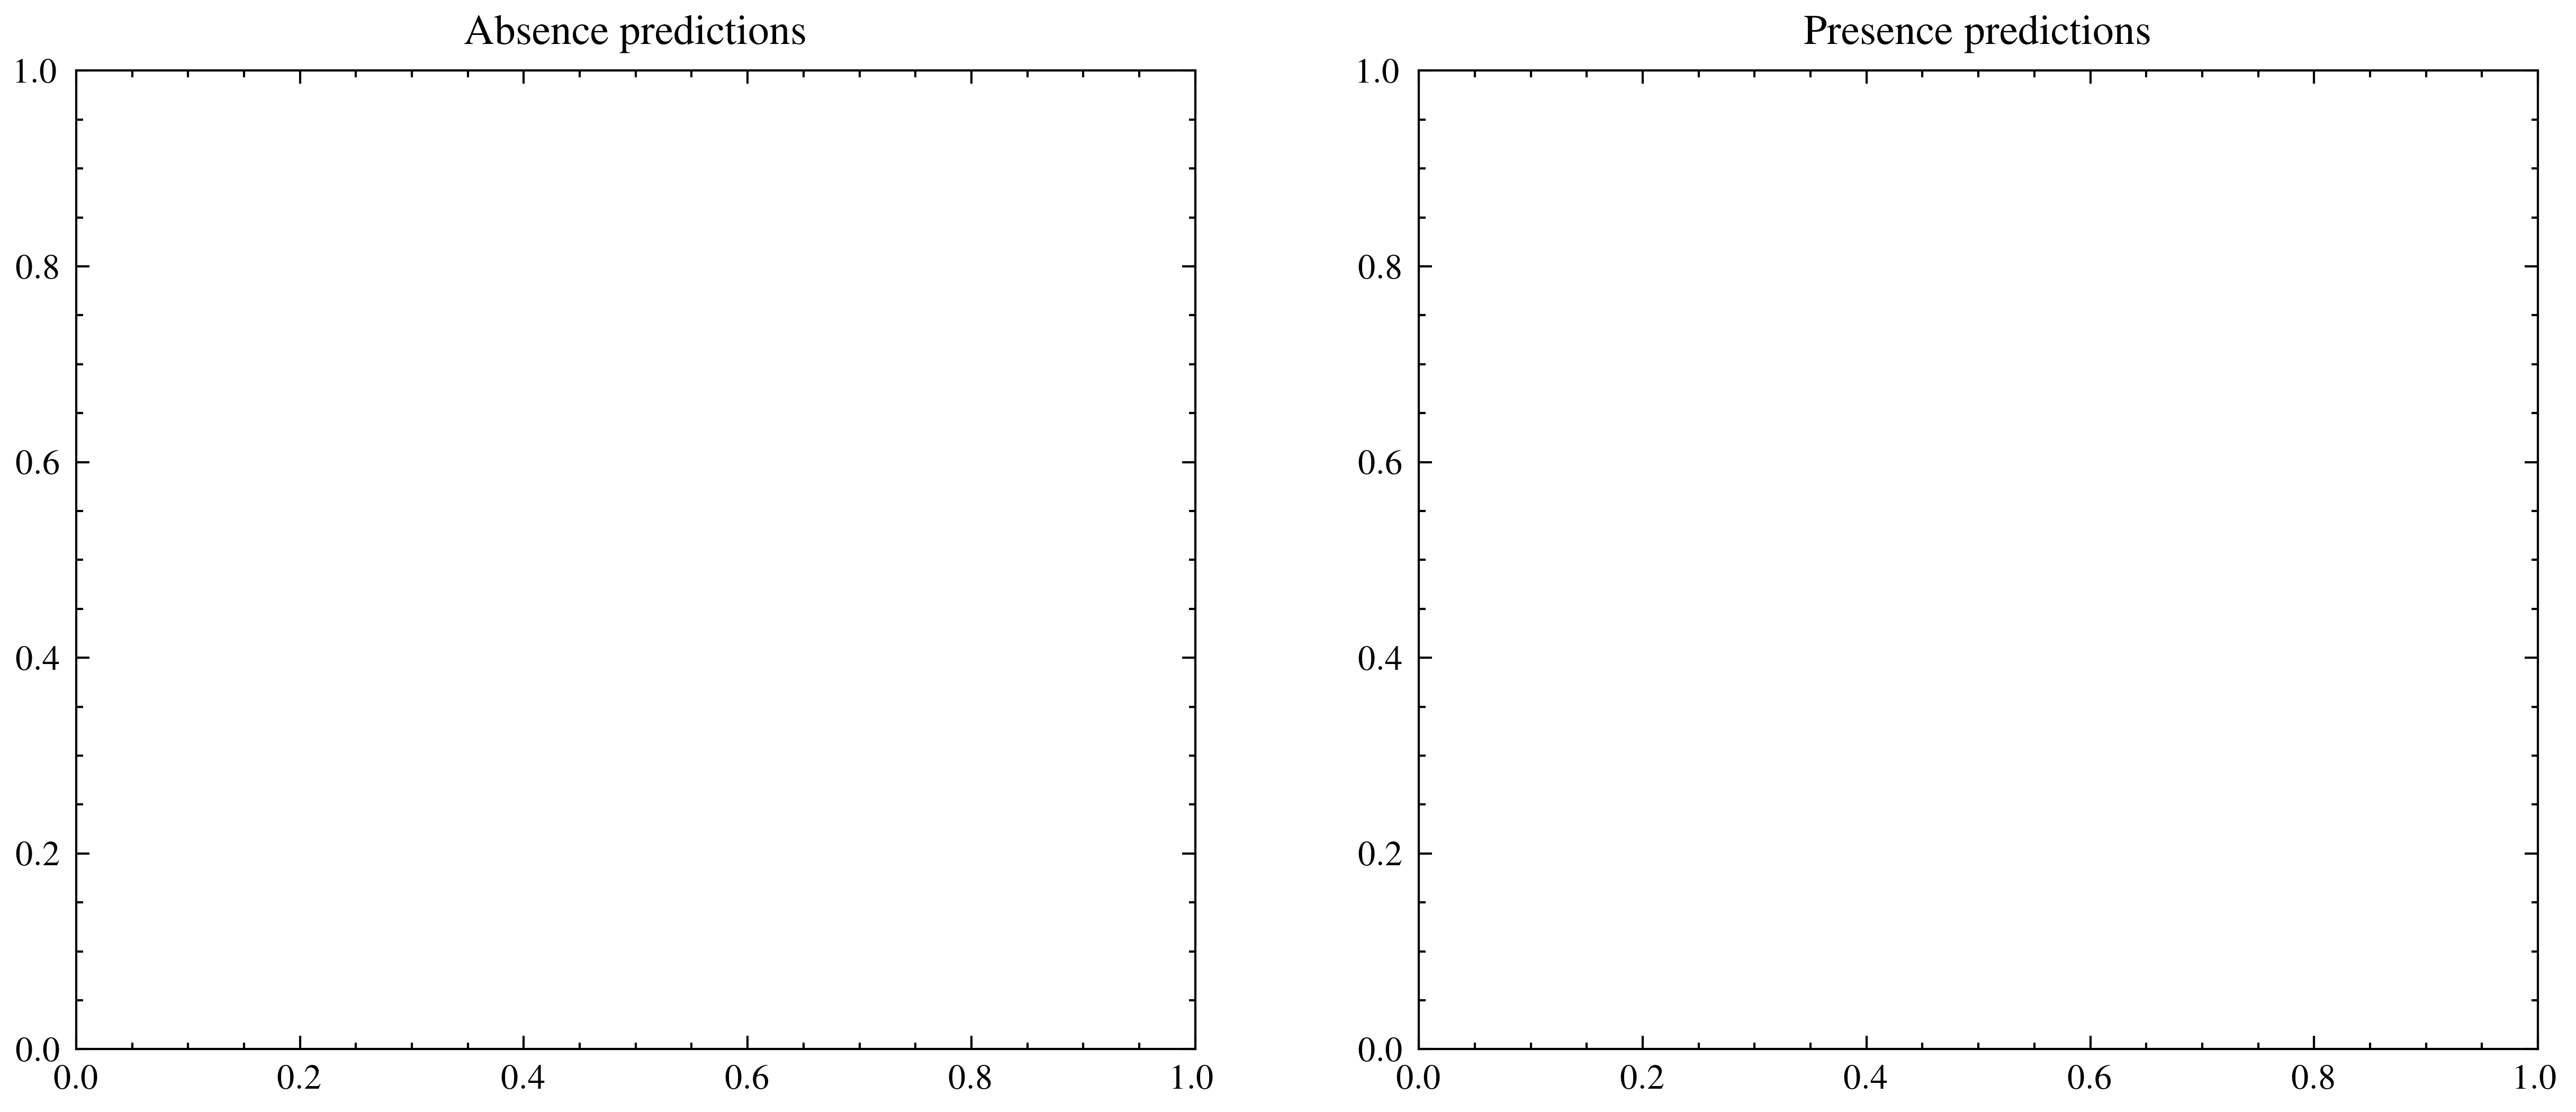

In [662]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
roc_args = {"marker":".", "linestyle":"--"}

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# axes[0].title.set_text(f"ROC")
axes[0].title.set_text(f"Absence predictions")
axes[1].title.set_text(f"Presence predictions")

# RocCurveDisplay.from_predictions(test_df["correct"], probs[:,1], ax=axes[0], **roc_args);

for ax, prediction in ((axes[0], -1), (axes[1], 1)):
    train_df = full_df[full_df["train"] * full_df["prediction"] == prediction]
    test_df = full_df[(~full_df["train"]) * full_df["prediction"] == prediction]

    xgboost = HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.01,
        min_samples_leaf=10,
        max_iter=200,
        monotonic_cst=np.ones_like(basic_features, dtype=int)
    ).fit(train_df[basic_features], train_df["correct"])

    probs = xgboost.predict_proba(test_df[basic_features])

    dis = PrecisionRecallDisplay.from_predictions(
        test_df["correct"], probs[:,1], name="PR", plot_chance_level=False, drop_intermediate=True, ax=ax, drawstyle="default", **roc_args
    )

    ax.set_ylim(0.5, 1)
    ax.legend()
    ax.grid()

plt.show()

6828
9792


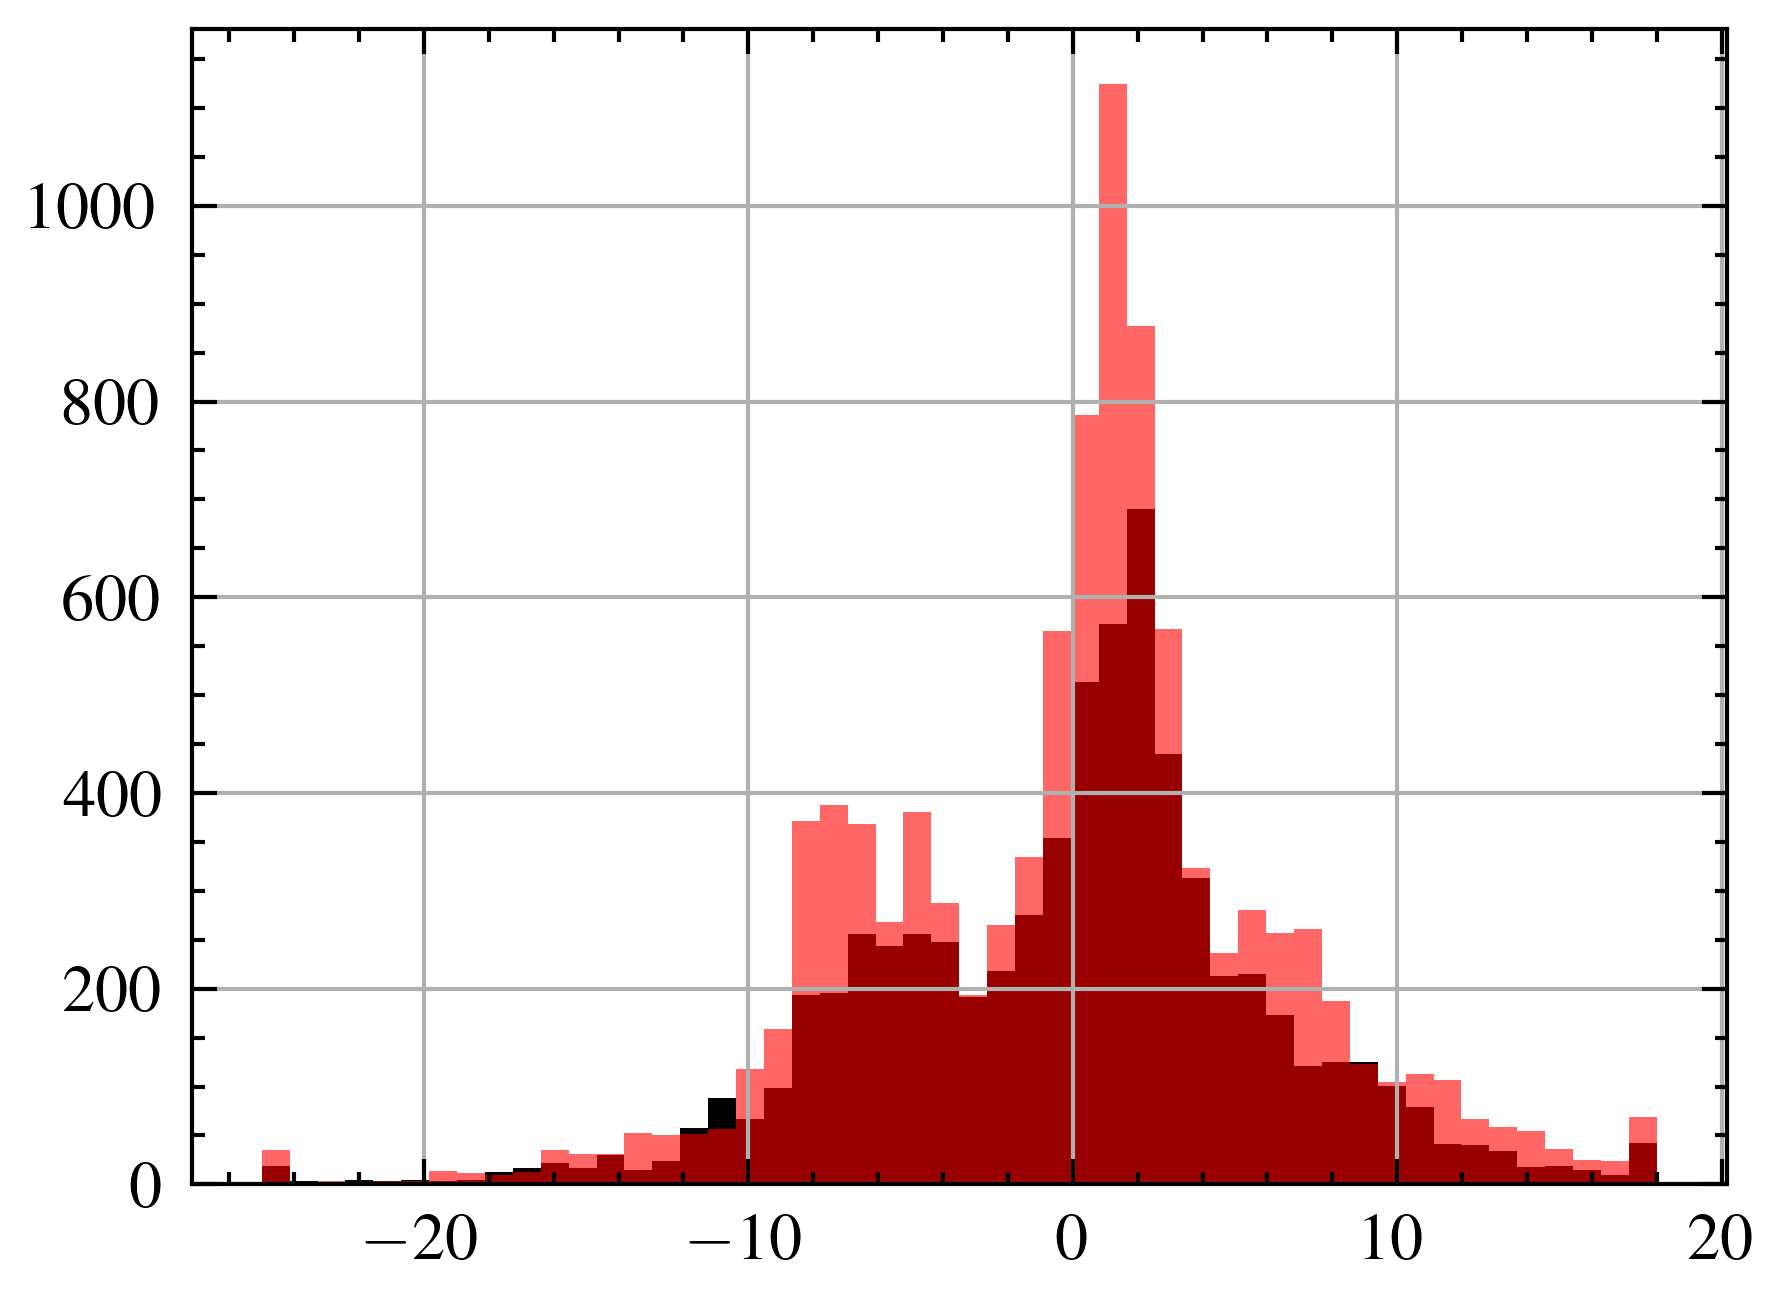

In [394]:
mask = full_df["prediction"] == -1

df = full_df[mask * full_df["correct"] == -1][basic_features]
df = (df - df.mean()) / df.std()
df.fillna(0).apply(axis=1, func=sum).clip(-25, 18).hist(bins=50)
print(len(df))

df = full_df[mask * full_df["correct"] == 1][basic_features]
df = (df - df.mean()) / df.std()
df.fillna(0).apply(axis=1, func=sum).clip(-25, 18).hist(bins=50, alpha=.6)
print(len(df))

In [ ]:
full_df["um7_taxqa_responses_by_phylum"].sort_values() * 10000

0       -0.0
15550   -0.0
15549   -0.0
15548   -0.0
15547   -0.0
        ... 
7768    -0.0
7767    -0.0
7766    -0.0
7764    -0.0
23317   -0.0
Name: um7_taxqa_responses_by_phylum, Length: 23318, dtype: float64

In [668]:
mask = full_df["prediction"] == -1
df = full_df[mask][basic_features]

df_c = df[full_df["correct"] == 1]
df_i = df[full_df["correct"] == -1]

diff = (df_c.mean() - df_i.mean()).fillna(0) / df.std().fillna(1)
diff

/tmp/ipykernel_1180059/139221350.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = df[full_df["correct"] == 1]
/tmp/ipykernel_1180059/139221350.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_i = df[full_df["correct"] == -1]


um7_taxqa_responses_by_family        0.054499
um5_record_count_by_stateprovince   -0.120458
um6_taxqa_accuracy_by_phylum              NaN
um1_total_score                      0.136811
um4_phrasing_agreement               0.579682
um5_record_count_by_county          -0.077150
um6_taxqa_accuracy_by_order         -0.024443
um5_record_count_by_species          0.145715
um7_taxqa_responses_by_genus         0.082263
um6_taxqa_accuracy_by_family         0.059026
um7_taxqa_responses_by_phylum             NaN
um5_record_count_by_genus            0.125157
um5_record_count_by_family           0.097754
um2_abstains                         0.136101
um4_phrasing_score_var               0.480999
um6_taxqa_accuracy_by_class         -0.049436
um5_record_count_by_phylum           0.110646
um6_taxqa_accuracy_by_genus          0.118148
um1_percent_score                         NaN
dtype: float64

In [401]:
mask = full_df["prediction"] == -1
df = full_df[mask][basic_features]

df_c = df[full_df["correct"] == 1]
df_i = df[full_df["correct"] == -1]

diff = (df_c.mean() - df_i.mean()).fillna(0) / abs(df.max())
diff

/tmp/ipykernel_1180059/3205554960.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = df[full_df["correct"] == 1]
/tmp/ipykernel_1180059/3205554960.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_i = df[full_df["correct"] == -1]


um7_taxqa_responses_by_family             inf
um5_record_count_by_stateprovince   -0.035874
um6_taxqa_accuracy_by_phylum         0.000000
um1_total_score                      0.007074
um4_phrasing_agreement               0.210673
um5_record_count_by_county          -0.011998
um6_taxqa_accuracy_by_order         -0.004288
um5_record_count_by_species          0.006985
um7_taxqa_responses_by_genus              inf
um6_taxqa_accuracy_by_family         0.012824
um7_taxqa_responses_by_phylum             NaN
um5_record_count_by_genus            0.015747
um5_record_count_by_family           0.017657
um2_abstains                              inf
um4_phrasing_score_var                    inf
um6_taxqa_accuracy_by_class         -0.009073
um5_record_count_by_phylum           0.024477
um6_taxqa_accuracy_by_genus          0.028235
um1_percent_score                    0.000000
dtype: float64

In [397]:
tdf = train_df
df = tdf[tdf["target"] == -1][basic_features]
pabs = pd.Series(xgboost.predict_proba(df)[:,1]).hist(bins=50)

ppres = df = tdf[tdf["target"] == 1][basic_features]
pd.Series(xgboost.predict_proba(df)[:,1]).hist(bins=50, alpha=.6)

NameError: name 'xgboost' is not defined

In [155]:
# train_df = full_df[full_df["train"]]
# test_df = full_df[(~full_df["train"])]

df = test_df[test_df["prediction"] == -1]
balanced_df = pd.concat([df[df["correct"] == 1].sample(len(df[df["correct"] == -1]), replace=False), df[df["correct"] == -1]])
balanced_df

KeyError: 'train'

In [398]:
full_df.groupby("prediction")["um1_total_score"].mean()

prediction
-1    9.943261
 1    7.212988
Name: um1_total_score, dtype: float64

In [250]:
um = "um1_total_score"
np.mean(um_diffs[um])
f"{np.mean(um_diffs[um]):.2%} ± {np.std(um_diffs[um]):.2%}"

'-1.11% ± 0.14%'

In [259]:
botp

1.0

In [272]:
fold_df[fold_df["prediction"] == 1][fold_df["um1_total_score"] == 10]["correct"].mean()

/tmp/ipykernel_1180059/2364050463.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fold_df[fold_df["prediction"] == 1][fold_df["um1_total_score"] == 10]["correct"].mean()


0.6413741034352586

In [672]:
sum(full_df["prediction"] == -1)

16620

In [689]:
p = .5

df = full_df[full_df["prediction"] == -1]

# Balance #correct and #incorrect
# df = pd.concat([df[df["correct"] == 1].sample(len(df[df["correct"] == -1]), replace=False), df[df["correct"] == -1]])

um_diffs = { f: [] for f in basic_features }
for fold, (subset, _) in enumerate(cv.split(df)):
    fold_df = df#.iloc[subset]
    n = int(len(fold_df) * p)
    for um in basic_features:
        x = np.sort(fold_df[um])
        botp = x[n]
        topp = x[-n]

        lower_acc = (fold_df[fold_df[um] <= botp]["correct"] * .5 + .5).mean()
        upper_acc = (fold_df[fold_df[um] >= topp]["correct"] * .5 + .5).mean()
        um_diffs[um].append(upper_acc - lower_acc)

sorted_features = np.sort(basic_features)
for i, um in enumerate(sorted_features):
    print(f"{np.mean(um_diffs[um]):.2%} ± {np.std(um_diffs[um] * 2):.2%}\t{um}")

2.94% ± 0.00%	um1_percent_score
3.41% ± 0.00%	um1_total_score
0.41% ± 0.00%	um2_abstains
11.31% ± 0.00%	um4_phrasing_agreement
12.42% ± 0.00%	um4_phrasing_score_var
-0.27% ± 0.00%	um5_record_count_by_county
1.84% ± 0.00%	um5_record_count_by_family
2.67% ± 0.00%	um5_record_count_by_genus
1.90% ± 0.00%	um5_record_count_by_phylum
4.50% ± 0.00%	um5_record_count_by_species
-1.48% ± 0.00%	um5_record_count_by_stateprovince
-0.53% ± 0.00%	um6_taxqa_accuracy_by_class
0.85% ± 0.00%	um6_taxqa_accuracy_by_family
2.74% ± 0.00%	um6_taxqa_accuracy_by_genus
-0.00% ± 0.00%	um6_taxqa_accuracy_by_order
0.00% ± 0.00%	um6_taxqa_accuracy_by_phylum
0.45% ± 0.00%	um7_taxqa_responses_by_family
0.62% ± 0.00%	um7_taxqa_responses_by_genus
0.00% ± 0.00%	um7_taxqa_responses_by_phylum


In [280]:
sorted_features = np.sort(features)
for i, um in enumerate(sorted_features):
    print(f"{np.mean(um_diffs[um]):.2%} ± {np.std(um_diffs[um] * 2):.2%}\t{um}")

8.44% ± 0.00%	um1_percent_score
8.55% ± 0.00%	um1_total_score
0.10% ± 0.00%	um2_abstains
10.73% ± 0.00%	um4_phrasing_agreement
5.95% ± 0.00%	um4_phrasing_score_var
0.06% ± 0.00%	um5_record_count_by_county
-1.99% ± 0.00%	um5_record_count_by_family
-4.71% ± 0.00%	um5_record_count_by_genus
-0.94% ± 0.00%	um5_record_count_by_phylum
-5.42% ± 0.00%	um5_record_count_by_species
-4.70% ± 0.00%	um5_record_count_by_stateprovince
-0.84% ± 0.00%	um6_taxqa_accuracy_by_class
1.03% ± 0.00%	um6_taxqa_accuracy_by_family
1.69% ± 0.00%	um6_taxqa_accuracy_by_genus
-0.50% ± 0.00%	um6_taxqa_accuracy_by_order
0.00% ± 0.00%	um6_taxqa_accuracy_by_phylum
-0.12% ± 0.00%	um7_taxqa_responses_by_family
0.15% ± 0.00%	um7_taxqa_responses_by_genus
0.00% ± 0.00%	um7_taxqa_responses_by_phylum


In [239]:
set(all_features) - set(features)

{'um7_taxqa_responses_by_class', 'um7_taxqa_responses_by_order'}

In [191]:
for fold, (train, test) in enumerate(cv.split(df)):
    print(train)

[1343 1344 1345 ... 6711 6712 6713]
[   0    1    2 ... 6711 6712 6713]
[   0    1    2 ... 6711 6712 6713]
[   0    1    2 ... 6711 6712 6713]
[   0    1    2 ... 5369 5370 5371]


In [ ]:
um = "um6_taxqa_accuracy_by_family"

df = train_df
p = .05
n = int(len(df) * p)

x = np.sort(df[um])
botp = x[n]
topp = x[-n]

lower_acc = (df[df[um] <= botp]["correct"] * .5 + .5).mean()
upper_acc = (df[df[um] >= topp]["correct"] * .5 + .5).mean()

print(botp)
print(topp)
print(lower_acc)
print(upper_acc)

0.525
1.0
0.8807106598984772
0.7957927142124166


In [ ]:
x = df["um6_taxqa_accuracy_by_family"]
p = .2
botp = np.sort(x)[int(len(x) * p)]

In [ ]:
test_df[test_df["um6_taxqa_accuracy_by_family"] >= topp]["correct"].mean() * .5 - test_df[test_df["um6_taxqa_accuracy_by_family"] <= botp]["correct"].mean() * .5

0.07856428787614758

<Axes: >

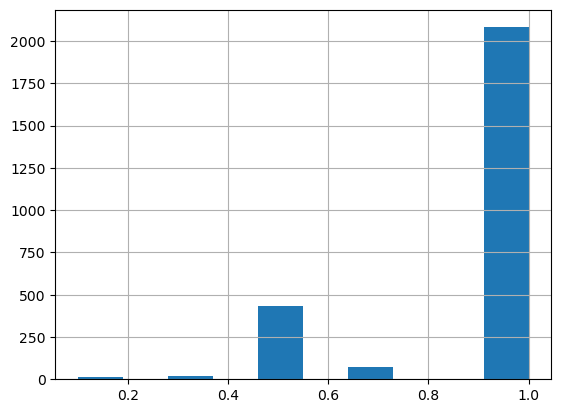

In [ ]:
test_df["um6_taxqa_accuracy_by_family"].hist()

<Axes: xlabel='um6_taxqa_accuracy_by_family'>

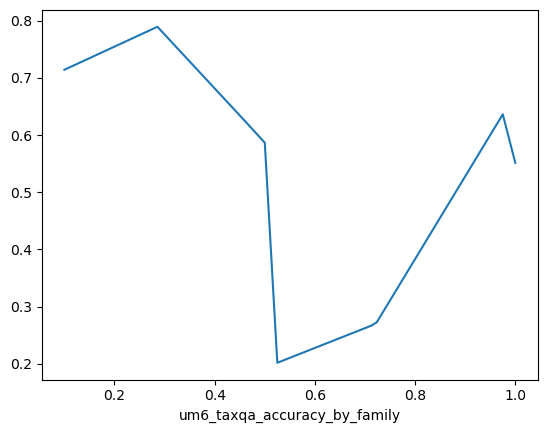

In [ ]:
test_df.groupby("um6_taxqa_accuracy_by_family")["correct"].mean().plot()

In [ ]:
full_df.groupby("um5_record_count_by_family")["correct"].mean()

um5_record_count_by_family
6770.0       0.146119
10054.0      0.134796
10330.0      0.523810
10839.0      0.163265
10859.0      0.334465
12311.0      0.126492
14683.0      0.134615
17016.0      0.353846
17435.0      0.005025
17680.0      0.522034
19156.0      0.028037
19277.0      0.305660
19439.0      0.267532
25504.0      0.006479
26085.0      0.119730
26101.0      0.425641
27966.0      0.271795
32374.0      0.289428
32819.0      0.525952
32996.0      0.049645
37985.0      0.187608
41393.0      0.218589
41572.0      0.456110
47637.0      0.366667
50040.0      0.568182
55127.0      0.290210
62564.0      0.097561
63170.0      0.123435
65120.0      0.109155
94609.0      0.279438
95228.0      0.038328
147301.0     0.272097
180350.0     0.284746
215349.0     0.328836
236264.0     0.074205
292297.0     0.362989
298582.0     0.435009
304055.0     0.234347
678337.0     0.472566
687073.0     0.689354
812274.0     0.128814
1288466.0    0.642066
1335954.0    0.405694
1477141.0    0.310696
28181

In [ ]:
full_df.sort_values("um4_phrasing_agreement")[["um4_phrasing_agreement", "responses", "scores", "prediction", "correct"]]

,um4_phrasing_agreement,responses,scores,prediction,correct
0,-1.000000,No No No No No No No No No No,0,-1,-1
13822,-1.000000,No No No No No No No No No No,0,-1,1
13823,-1.000000,No No No No No No No No No No,0,-1,1
13824,-1.000000,No No No No No No No No No No,0,-1,1
13825,-1.000000,No No No No No No No No No No,0,-1,1
...,...,...,...,...,...
12714,0.666667,No No No No No No Yes Yes No No,2,1,1
8641,0.666667,No No Yes No No No No No No No,1,1,1
12718,0.666667,No No No No No No No No No No,0,-1,-1
8617,0.666667,No No No Yes No No No No No Yes,2,1,1


In [ ]:
df = full_df[full_df["prediction"] == -1]
abs_df = pd.concat([df[df["correct"] == 1].sample(len(df[df["correct"] == -1]), replace=False), df[df["correct"] == -1]])

df = full_df[full_df["prediction"] == 1]
pres_df = pd.concat([df[df["correct"] == 1].sample(len(df[df["correct"] == -1]), replace=False), df[df["correct"] == -1]])

for um in all_features:
    t = np.sort(list(set(full_df[um])))

    df = abs_df
    abs_perf = max([((df[um] >= t) == (df["correct"] == 1)).mean() for t in set(df[um])])

    df = pres_df
    pres_perf = max([((df[um] >= t) == (df["correct"] == 1)).mean() for t in set(df[um])])
    # plt.plot(t, y)
    print(f"{max(abs_perf, pres_perf):.2%} . . {abs_perf:.2%} . {pres_perf:.2%} . {um}")

56.93% . . 51.04% . 56.93% . um1_total_score
56.76% . . 50.00% . 56.76% . um1_percent_score
51.04% . . 51.04% . 50.43% . um2_abstains
57.10% . . 50.00% . 57.10% . um3_accuracy_by_kingdom
54.51% . . 53.87% . 54.51% . um3_accuracy_by_phylum
56.83% . . 54.20% . 56.83% . um3_accuracy_by_family
52.42% . . 52.09% . 52.42% . um3_accuracy_by_country
56.82% . . 56.82% . 55.74% . um3_accuracy_by_stateprovince
50.00% . . 50.00% . 50.00% . um4_phrasing_agreement
64.10% . . 64.10% . 55.47% . um4_phrasing_score_var
57.10% . . 50.00% . 57.10% . um5_record_count_by_kingdom
53.61% . . 52.49% . 53.61% . um5_record_count_by_phylum
52.47% . . 52.47% . 52.25% . um5_record_count_by_family
50.00% . . 50.00% . 50.00% . um6_taxqa_accuracy_by_phylum
50.20% . . 50.00% . 50.20% . um6_taxqa_accuracy_by_class
50.60% . . 50.18% . 50.60% . um6_taxqa_accuracy_by_order
52.85% . . 52.18% . 52.85% . um6_taxqa_accuracy_by_family
52.73% . . 52.73% . 52.42% . um6_taxqa_accuracy_by_genus
50.00% . . 50.00% . 50.00% . um7_taxq

In [ ]:
(balanced_df["correct"] == 1).mean()

0.5

56.97%	um3_accuracy_by_stateprovince


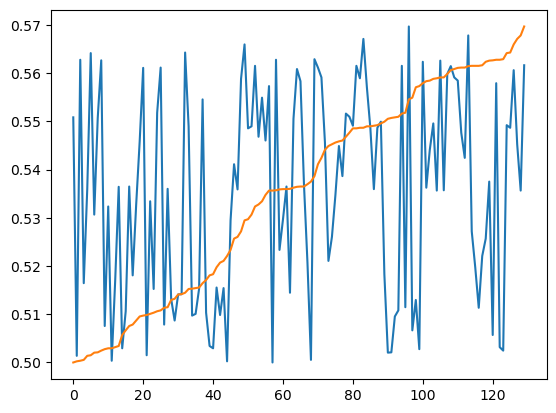

In [ ]:
um = "um3_accuracy_by_stateprovince"
t = np.sort(list(set(balanced_df[um])))
y = [((balanced_df[um] >= t) == (balanced_df["correct"] == 1)).mean() for t in set(balanced_df[um])]
plt.plot(range(len(y)), y)
plt.plot(range(len(y)), np.sort(y))
print(f"{max(y):.2%}\t{um}")

In [ ]:
np.max(y)

0.6427652457329102